# Hyperbolic polaritons in nanostructured hBN

Note: the cost of running the entire notebook is larger than 1 FlexCredit.

Surface Phonon Polaritons (SPhPs) are hybrid light-matter waves that arise from the coupling of an electromagnetic wave with the optical phonons of the material. SPhPs are particularly interesting because they can confine light at the nanoscale, far below the diffraction limit. This confinement can lead to strong light-matter interactions, making SPhPs useful for a variety of applications.

Hexagonal boron nitride (hBN) is a van der Waals material that has gained significant attention in the field of nanophotonics due to its ability to support SPhPs in mid-infrared. hBN is a naturally hyperbolic material, meaning it exhibits hyperbolic dispersion for phonon polaritons. These hyperbolic SPhPs can propagate with in-plane wavevectors much larger than the wavevector of light in vacuum, leading to highly confined polaritons.

The in-plane permittivity of hBN is isotropic ($\varepsilon_{xx}=\varepsilon_{yy}$). Therefore, the SPhP propagates isotropically. In the landmark paper `Peining Li et al., Infrared hyperbolic metasurface based on nanostructured van der Waals materials. Science 359, 892-896 (2018).` [DOI: 10.1126/science.aaq1704](https://www.science.org/doi/10.1126/science.aaq1704), the authors proposed a metamaterial consisting of nanostructured hBN. The nanostructure results in an effective medium with anisotropic in-plane permittivity and thus it supports unidirectional SPhP. In this notebook, we simulate and compare the SPhPs in a uniform hBN layer and a nanostructured hBN layer. Unidirectional SPhP is observed in the hBN metamaterial and the results are shown to be consistent with these in the publication.

<img src="img/hBN_metamaterial.png" width="800" alt="Schematic of the hBN metamaterial">

As a side note, using anisotropic metamaterial as an effective medium has also been demonstrated to be an useful engineering technique in silicon integrated photonics.  Please see the two case studies: [waveguide crosstalk reduction](https://www.flexcompute.com/tidy3d/examples/notebooks/ZeroCrossTalkTE/) and the [broadband polarizer](https://www.flexcompute.com/tidy3d/examples/notebooks/SWGBroadbandPolarizer/).

For more interesting contents in the realm of nanophotonics, please check out the case studies on [Anderson localization](https://www.flexcompute.com/tidy3d/examples/notebooks/AndersonLocalization/), [non-Hermitian metagratings](https://www.flexcompute.com/tidy3d/examples/notebooks/NonHermitianMetagratings/), and [plasmonic nanoantennas](https://www.flexcompute.com/tidy3d/examples/notebooks/PlasmonicYagiUdaNanoantenna/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## SPhP on Uniform hBN Slab

### Simulation Setup 

The frequencies of interest are 1405 1/cm, 1415 1/cm, and 1425 1/cm. In mid-infrared, 1/cm (wavenumber) is conventionally used while in `Tidy3D` the native frequency unit is Hz. We can convert 1/cm to Hz by multiplying `td.C_0/1e4`. The native length unit in `Tidy3D` is $\mu m$ so `td.C_0` is in the unit for $\mu m$/s. Hence, there is an additional factor of $1e4$.

In [2]:
wavenumbers = np.array([1405, 1415, 1425])  # wavenumbers of interest in 1/cm
freqs = td.C_0 * wavenumbers / 1e4  # frequencies of interest in Hz

The in-plane and out-of-plane permittivities of the hBN are given by [Lorentz](../_autosummary/tidy3d.Lorentz.html) oscillators with the parameter values taken from the [referenced paper](https://www.science.org/doi/10.1126/science.aaq1704). The hBN is on a SiO$_2$/Si wafer. For SiO$_2$, the permittivity is also described by [Lorentz](../_autosummary/tidy3d.Lorentz.html) while Si is considered to have a constant permittivity of 12.

In [3]:
w_TO_z = 785 * td.C_0 / 1e4  # TO phonon frequency in Hz for the out-of-plane permittivity
w_LO_z = 845 * td.C_0 / 1e4  # LO phonon frequency in Hz for the out-of-plane permittivity
eps_inf_z = 2.8  # high frequency permittivity for the out-of-plane permittivity
gamma_z = 1 * td.C_0 / 1e4  # damping coefficient for the out-of-plane permittivity

# define the out-of-plane permittivity
coeffs_z = [(eps_inf_z * (w_LO_z**2 / w_TO_z**2 - 1), w_TO_z, gamma_z / 2)]
hBN_z = td.Lorentz(eps_inf=eps_inf_z, coeffs=coeffs_z)

# similarly for the in-plane permittivity
w_TO_x = 1395 * td.C_0 / 1e4
w_LO_x = 1630 * td.C_0 / 1e4
eps_inf_x = 3
gamma_x = 2 * td.C_0 / 1e4

coeffs_x = [(eps_inf_x * (w_LO_x**2 / w_TO_x**2 - 1), w_TO_x, gamma_x / 2)]
hBN_x = td.Lorentz(eps_inf=eps_inf_x, coeffs=coeffs_x)

# define hBN as an anisotropic medium
hBN = td.AnisotropicMedium(xx=hBN_x, yy=hBN_x, zz=hBN_z)

# define Si as a constant permittivity
Si = td.Medium(permittivity=12)

# define SiO2 as an isotropic dispersive medium using Lorentz
coeffs_sio2 = [
    (0.6753, 1072.27 * td.C_0 / 1e4, 67.2179 * td.C_0 / 2e4),
    (0.0929, 805.2 * td.C_0 / 1e4, 75.7006 * td.C_0 / 2e4),
    (1.0218, 457.61 * td.C_0 / 1e4, 44.5775 * td.C_0 / 2e4),
]

SiO2 = td.Lorentz(eps_inf=2.1, coeffs=coeffs_sio2)

The thickness of hBN is 20 nm and the thickness of SiO$_2$ is 250 nm. 

In [4]:
h_bn = 0.02  # thickness of the hBN layer
h_sio2 = 0.25  # thickness of the SiO2 layer
inf_eff = 1e2  # effective infinity

We first investigate the SPhP in a uniform hBN slab. The system consists of three layers: a 20 nm hBN, a 250 nm SiO$_2$, and a thick Si substrate. Each layer can be defined as a [Box](../_autosummary/tidy3d.Box.html).

In [5]:
# define the hBN slab
hBN_slab = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -h_bn), rmax=(inf_eff, inf_eff, 0)),
    medium=hBN,
)

# define the SiO2 slab
SiO2_slab = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -h_bn - h_sio2), rmax=(inf_eff, inf_eff, -h_bn)
    ),
    medium=SiO2,
)

# define the Si substrate
Si_slab = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -h_bn - h_sio2)
    ),
    medium=Si,
)

To excite the SPhP, a [PointDipole](../_autosummary/tidy3d.PointDipole.html) source 200 nm above the hBN top surface is used. The momentum of SPhP is much higher than that of the free-space photon at the same frequency. Therefore, SPhP can not be excited by sources like a plane wave due to the momentum mismatch. The [PointDipole](../_autosummary/tidy3d.PointDipole.html) excitation contains a broad range of momentum, which can couple to SPhP.

To visualize the excited SPhP, we define a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) 30 nm above the hBN top surface.

In [6]:
dipole_z = 0.2  # z position of the point dipole
monitor_z = 0.03  # z position of the field monitor

# define a point dipole source
point_dipole = td.PointDipole(
    center=(0, 0, dipole_z),
    source_time=td.GaussianPulse(freq0=freqs[1], fwidth=freqs[1] / 10),
    polarization="Ez",
)

# define a field monitor
field_monitor = td.FieldMonitor(
    center=(0, 0, monitor_z), size=(td.inf, td.inf, 0), freqs=freqs, name="field"
)

Next we define a [Simulation](../_autosummary/tidy3d.Simulation.html) using the previously defined components. A few points to note:

- The `run_time` needs to be sufficiently long to fully capture the propagation of SPhP. 

- A fine grid needs to be used since SPhP has a small wavelength. 

- The coupling efficiency of the [PointDipole](../_autosummary/tidy3d.PointDipole.html) to the SPhP is relatively small so we also lower the `shutoff` threshold from the default `1e-5` to `1e-7` to ensure simulation accuracy.

- The system has two mirror symmetries in the `x` and `y` directions. Therefore, we set `symmetry=(1,1,0)`, which reduces the simulation domain size by a factor of 4. Even though the simulation domain size is not large, due to the fine grid and long `run_time`, the simulation still requires a good amount of computation.

- We use [Absorber](../_autosummary/tidy3d.Absorber.html) instead of PML as the boundary condition since the simulation domain size is small compared to the wavelength. Using PML can also work in principle as long as the evanescent field does not leak into PML. For safety, we will just use [Absorber](../_autosummary/tidy3d.Absorber.html).

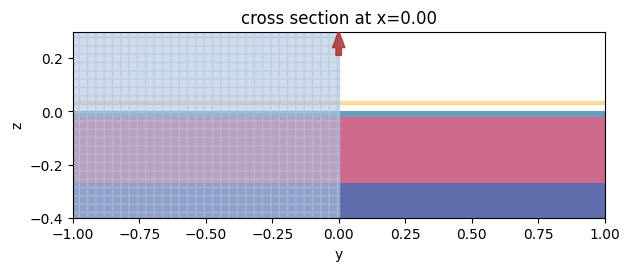

In [7]:
Lx = 12  # simulation domain size in x
Ly = 12  # simulation domain size in y
Lz = 1  # simulation domain size in z

run_time = 1e-11  # simulation run time in second

# define simulation for the uniform hBN slab
sim_uniform = td.Simulation(
    center=(0, 0, 0),
    size=(Lx, Ly, Lz),
    sources=[point_dipole],
    structures=[hBN_slab, SiO2_slab, Si_slab],
    monitors=[field_monitor],
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Absorber()),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=50, wavelength=td.C_0 / freqs[0]),
    run_time=run_time,
    symmetry=(1, 1, 0),
    shutoff=1e-7,
)

# visiualize the cross section of the simulation domain
ax = sim_uniform.plot(x=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.4, 0.3)
plt.show()

Submit the simulation to run on the cloud.

In [8]:
sim_data_uniform = web.run(sim_uniform, task_name="hbn_slab", path="data/simulation_data.hdf5")

[15:04:25] Created task 'hbn_slab' with task_id 'fdve-af0a71b2-03a5-4d77-93e0-55c7fb4d6d98v1'.        ]8;id=722205;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=61179;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#189\189]8;;\

           View task using web UI at                                                                  ]8;id=842251;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=308642;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=609622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-af0a71b2-03a5-4d77-93e0-55c7fb4d6d98v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=134959;https://tidy3d.simulation.cloud/workbench?taskId=fdve-af0a71b2-03a5-4d77-93e0-55c7fb4d6d98v1\taskId]8;;\]8;id=609622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-af0a71b2-03a5-4d77-93e0-55c7fb4d6d98v1\=]8;;\]8;id=821883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-af0a71b2-03a5-4d77-93e0-55c7fb4d6d98v1\fdve]8;;\]8;id=609622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-af0a71b2-03a5-4d77-93e0-55c7fb4d6d98v1\-af0a71b2-03a5-4d77-93e0-55c7fb4d6d9]8;;\              
           ]8;id=609622;https://tidy3d.simulation.cloud/workbench?taskId=fdve-af0a71b2-03a5-4d77-93e0-55c7fb4d6d98v1\8v1']8;;\.                                                                                                   

Output()

[15:04:30] status = queued                                                                            ]8;id=916850;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=651712;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#363\363]8;;\

Output()

[15:04:37] status = preprocess                                                                        ]8;id=577047;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=569369;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#357\357]8;;\

[15:04:44] Maximum FlexCredit cost: 2.658. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=585618;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=282399;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=57561;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=560291;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=629588;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=165084;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#389\389]8;;\

Output()

[15:14:50] early shutoff detected, exiting.                                                           ]8;id=153973;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=418302;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#403\403]8;;\

[15:14:51] status = postprocess                                                                       ]8;id=9771;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=692253;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#420\420]8;;\

Output()

[15:15:08] status = success                                                                           ]8;id=198511;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=752764;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#427\427]8;;\

Output()

[15:15:11] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=916320;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=40770;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#605\605]8;;\

### Result Visualization 

After the simulation is done, we will plot the real part of `Ez` to visualize the SPhP at various frequencies of interest. 

In [9]:
# define a helper function to plot Ez at all frequencies of interest
def plot_fields(sim_data):
    fig, ax = plt.subplots(len(wavenumbers), 1, figsize=(6, 12), tight_layout=True)

    for i, wavenumber in enumerate(wavenumbers):
        sim_data.plot_field("field", "Ez", "real", f=freqs[i], vmin=-3e3, vmax=3e3, ax=ax[i])
        ax[i].set_title(f"{wavenumber} 1/cm")

For the uniform hBN slab, the SPhP propagates isotropically along the surface so we observe a circular wave front. As the frequency increases, the SPhP wavelength decreases.

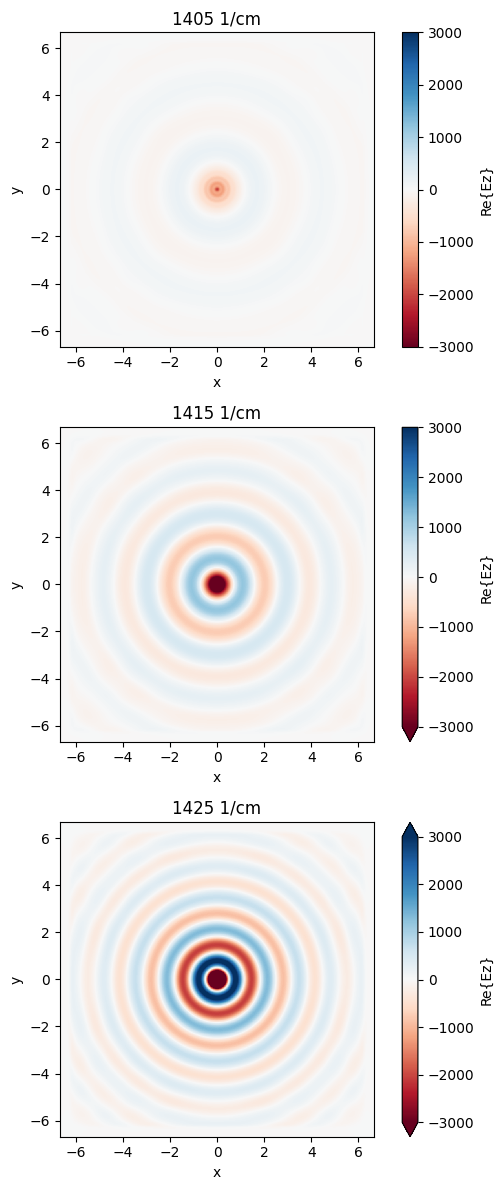

In [10]:
plot_fields(sim_data_uniform)

## SPhP on Nanostructured hBN Metamaterial 

### Simulation Setup 

As a comparison, here we simulate the nanostructured hBN metamaterial, where hBN is patterned into periodic gratings with a subwavelength period. This metamaterial can be described by an effective permittivity tensor such that 
$$\varepsilon_\mathrm{eff, x} = \left( \frac{1 - f}{\epsilon_\mathrm{x}} + f \right) ^{-1},$$ 
$$\varepsilon_\mathrm{eff,y}=\varepsilon_\mathrm{y}(1-f)+f,$$
$$\varepsilon_\mathrm{eff,z}=\varepsilon_\mathrm{z}(1-f)+f,$$
where $f=\frac{w}{w+g}$ is the filling fraction. Following this, we can plot the permittivity of hBN as well as the effective permittivity of the nanostructured hBN in the case of 70 nm ribbon width and 100 nm period. For the hBN, $Re(\varepsilon_x)=Re(\varepsilon_y)<0$ between 1400 1/cm and 1425 1/cm, which is why it supports isotropic SPhP as observed in the previous simulation. For the nanostructured hBN, only $Re(\varepsilon_{eff,y})<0$ so in principle it supports unidirectional SPhP. Next, we will confirm it with simulation.

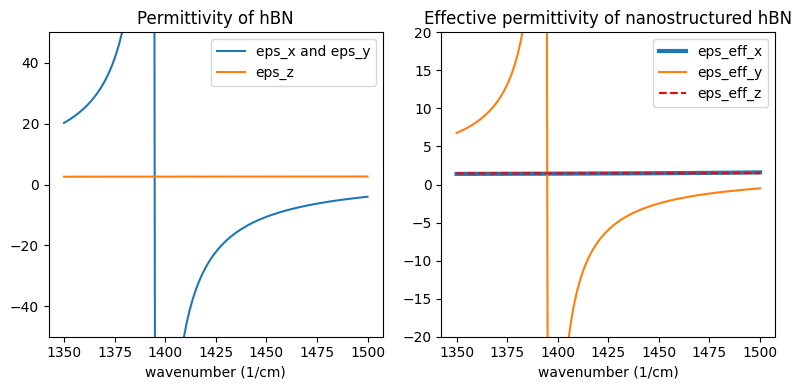

In [11]:
wn = np.linspace(1350, 1500, 100)  # wavenumber range
fq = wn * td.C_0 / 1e4  # frequency range
eps_x = hBN_x.eps_model(fq)  # permittivity of hBN in the x direction
eps_y = hBN_x.eps_model(fq)  # permittivity of hBN in the y direction
eps_z = hBN_z.eps_model(fq)  # permittivity of hBN in the z direction

w = 0.07  # width of the ribbon
g = 0.03  # width of the gap
frac = w / (w + g)  # filling fraction

eps_eff_x = 1 / (
    (1 - frac) / eps_x + frac
)  # effective permittivity of the metamaterial in the x direction
eps_eff_y = (
    eps_y * (1 - frac) + frac
)  # effective permittivity of the metamaterial in the y direction
eps_eff_z = (
    eps_z * (1 - frac) + frac
)  # effective permittivity of the metamaterial in the z direction

# plotting the hBN permittivity and the effective permittivity of the metamaterial
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax1.plot(wn, np.real(eps_x), label="eps_x and eps_y")
ax1.plot(wn, np.real(eps_z), label="eps_z")
ax1.set_xlabel("wavenumber (1/cm)")
ax1.legend()
ax1.set_title("Permittivity of hBN")
ax1.set_ylim(-50, 50)
ax2.plot(wn, np.real(eps_eff_x), linewidth=3, label="eps_eff_x")
ax2.plot(wn, np.real(eps_eff_y), label="eps_eff_y")
ax2.plot(wn, np.real(eps_eff_z), "--", c="red", label="eps_eff_z")
ax2.set_xlabel("wavenumber (1/cm)")
ax2.legend()
ax2.set_title("Effective permittivity of nanostructured hBN")
ax2.set_ylim(-20, 20)
plt.show()

To define the grating structure, we simply use a for loop.

In [12]:
grating_geo = []
N = int(Lx / (g + w))
for i in range(N):
    grating_geo.append(
        td.Box(center=(-Lx / 2 + i * (g + w), 0, -h_bn / 2), size=(w, inf_eff, h_bn))
    )

grating = td.Structure(geometry=td.GeometryGroup(geometries=grating_geo), medium=hBN)

For this simulation, it's better to have a mesh commensurate with the period of the nanostructure in the $x$ direction. Therefore, we define a uniform grid with the grid size set to a fraction of the period. For the $y$ and $z$ directions, we simply use the same automatic nonuniform grid as before.

The simulation for the nanostructured hBN can be defined by copying the previous simulation and updating the structures and grid setting.

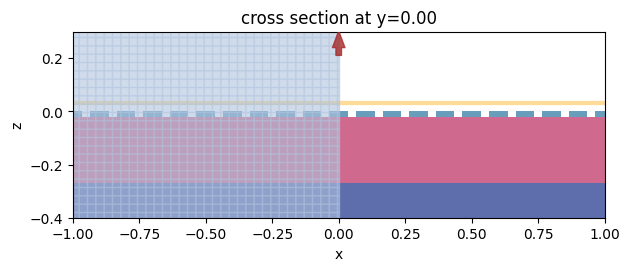

In [13]:
grid_x = td.UniformGrid(dl=(w + g) / 10)  # define a uniform grid in the x direction

# define an automatic nonuniform grid in the y and z direction
grid_y = td.AutoGrid(min_steps_per_wvl=50)
grid_z = td.AutoGrid(min_steps_per_wvl=50)

grid_spec = td.GridSpec(wavelength=td.C_0 / freqs[0], grid_x=grid_x, grid_y=grid_y, grid_z=grid_z)

# define the simulation by copying the updating the previous simulation
sim_grating = sim_uniform.copy(
    update={"structures": [grating, SiO2_slab, Si_slab], "grid_spec": grid_spec}
)

# visiualize the cross section of the simulation domain
ax = sim_grating.plot(y=0)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.4, 0.3)
plt.show()

In [14]:
sim_data_grating = web.run(sim_grating, task_name="hbn_grating", path="data/simulation_data.hdf5")

[15:15:16] Created task 'hbn_grating' with task_id 'fdve-c4914711-3084-4a85-bb4e-f52723bdca91v1'.     ]8;id=688384;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=910094;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#189\189]8;;\

           View task using web UI at                                                                  ]8;id=516022;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=581715;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#191\191]8;;\
           ]8;id=563839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4914711-3084-4a85-bb4e-f52723bdca91v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=665793;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4914711-3084-4a85-bb4e-f52723bdca91v1\taskId]8;;\]8;id=563839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4914711-3084-4a85-bb4e-f52723bdca91v1\=]8;;\]8;id=373480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4914711-3084-4a85-bb4e-f52723bdca91v1\fdve]8;;\]8;id=563839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4914711-3084-4a85-bb4e-f52723bdca91v1\-c4914711-3084-4a85-bb4e-f52723bdca9]8;;\              
           ]8;id=563839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c4914711-3084-4a85-bb4e-f52723bdca91v1\1v1']8;;\.                                                                                                   

Output()

[15:15:21] status = queued                                                                            ]8;id=472788;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=256239;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#363\363]8;;\

Output()

[15:15:35] status = preprocess                                                                        ]8;id=887577;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=354453;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#357\357]8;;\

[15:15:40] Maximum FlexCredit cost: 4.856. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=140496;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=804441;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=628950;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=66652;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=183020;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=786956;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#389\389]8;;\

Output()

[15:28:53] early shutoff detected, exiting.                                                           ]8;id=693602;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=589105;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#403\403]8;;\

[15:28:54] status = postprocess                                                                       ]8;id=907213;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=745218;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#420\420]8;;\

Output()

[15:29:04] status = success                                                                           ]8;id=823556;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=884387;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#427\427]8;;\

Output()

[15:29:07] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=293165;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=463590;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#605\605]8;;\

### Result Visualization 

After the simulation is complete, we plot the field distribution as before. Indeed we observe the unidirectional propagation of the SPhP in the $y$ direction supported by the hBN metamaterial, which is very distinctive from the SPhP in the uniform hBN slab. This result further validates the idea of nanoscale manipulation of light by geometric design. It opens up various possibilities for future nanophotonic engineering. 

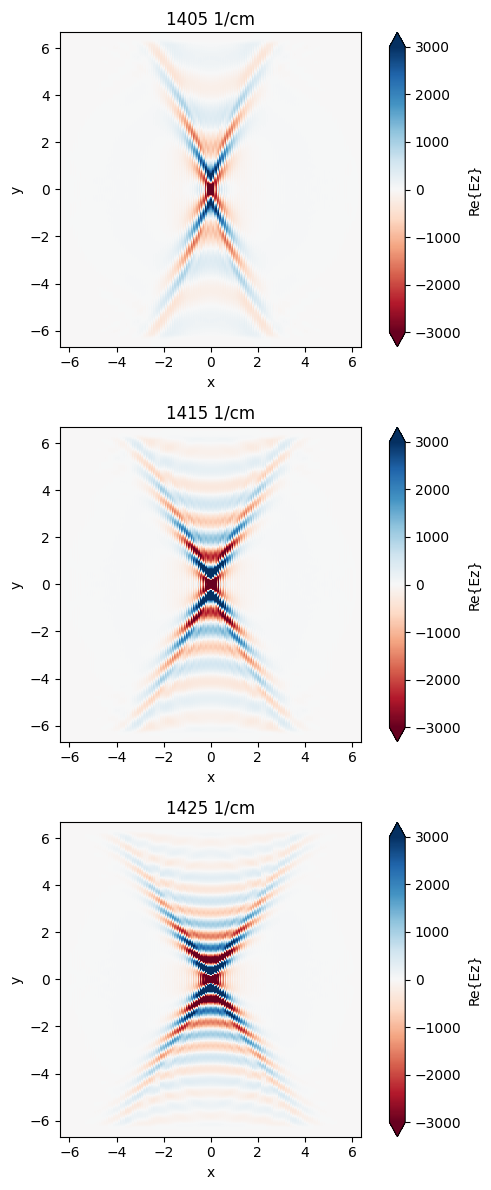

In [15]:
plot_fields(sim_data_grating)